# [**Tracer les surfaces de décision d'ensembles d'arbres sur le jeu de données iris**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_11_ensembles/plot_forest_iris.ipynb)<br/>([*Plot the decision surfaces of ensembles of trees on the iris dataset*](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html))

Tracé des surfaces de décision des forêts d'arbres aléatoires formés sur des paires de caractéristiques de l'ensemble de données d'iris.

Ce graphique compare les surfaces de décision apprises par un classifieur d'arbre de décision (première colonne), par un classifieur de forêt aléatoire (deuxième colonne), par un classifieur extra-arbres (troisième colonne) et par un classifieur AdaBoost (quatrième colonne).

Dans la première rangée, les classifieurs sont construits en utilisant uniquement les caractéristiques de largeur de sépale et de longueur de sépale, sur la deuxième rangée en utilisant uniquement la longueur de pétale et la longueur de sépale, et sur la troisième rangée en utilisant uniquement la largeur de pétale et la longueur de pétale.

Par ordre décroissant de qualité, lorsqu'ils sont entraînés (en dehors de cet exemple) sur les 4 caractéristiques à l'aide de 30 estimateurs et notés à l'aide d'une validation croisée de 10 plis, nous observons :

In [ ]:
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
ExtraTreesClassifier()  # 0.95 score
RandomForestClassifier()  # 0.94 score
AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))  # 0.94 score
DecisionTreeClassifier(max_depth=None)  # 0.94 score

DecisionTreeClassifier()

L'augmentation de `max_depth` pour AdaBoost réduit l'écart type des scores (mais le score moyen ne s'améliore pas).

Voir la sortie de la console pour plus de détails sur chaque modèle.

Dans cet exemple, vous pouvez essayer de :

1. faire varier le `max_depth` pour `DecisionTreeClassifier` et `AdaBoostClassifier`, essayez peut-être `max_depth=3` pour `DecisionTreeClassifier` ou `max_depth=None` pour `AdaBoostClassifier`

2. faire varier `n_estimators`

Il convient de noter que RandomForests et ExtraTrees peuvent être ajustés en parallèle sur plusieurs cœurs car chaque arbre est construit indépendamment des autres. Les exemples d'AdaBoost sont construits de manière séquentielle et n'utilisent donc pas plusieurs cœurs.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_forest_iris_001.png)

DecisionTree with features [0, 1] has a score of 0.9267
RandomForest with 30 estimators with features [0, 1] has a score of 0.9267
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9267
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8667
DecisionTree with features [0, 2] has a score of 0.9933
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933
DecisionTree with features [2, 3] has a score of 0.9933
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933


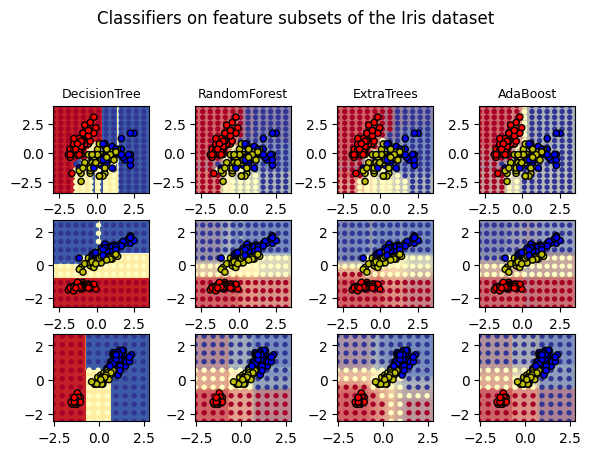

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators),
]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += f" with {len(model.estimators_)} estimators"
        print(
            f"{model_details} with features {pair} "
            f"has a score of {round(scores, 4)}"
        )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()